# LIBs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time 

from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler


import warnings
warnings.filterwarnings("ignore")

In [2]:
# Test gpu 
torch.cuda.is_available()

True

In [3]:
# Set seed
import random
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Load Data

In [4]:
# Load data from file
df=pd.read_csv("durhamtemp_1901_2019.csv")
df.dropna(inplace=True)
df.head()

,Year,Month,Day,Date,PPT.,Av temp,Tmax,Tmin
0,1901.0,1.0,1.0,01/01/1901,0.0,2.1,3.5,0.6
1,1901.0,1.0,2.0,02/01/1901,0.0,4.0,7.2,0.7
2,1901.0,1.0,3.0,03/01/1901,0.0,3.0,6.7,-0.7
3,1901.0,1.0,4.0,04/01/1901,0.0,3.7,7.9,-0.6
4,1901.0,1.0,5.0,05/01/1901,0.0,-0.3,1.2,-1.7


 Assuming that the temperature for 365 days in a future year depends on the temperature of the last 1000 days (Av temp), the average precipitation (PPT.), the month (Month)

In [5]:
# Extract the columns of features in the hypothesis
X_feas = df[["Av temp","PPT. ","Month"]].values
Y_pred = df["Av temp"].values.reshape(-1, 1)
print(X_feas.shape)
print(Y_pred.shape)

(43464, 3)
(43464, 1)


In [6]:
# normalisation
scaler1 = MinMaxScaler()
X_feas_norm= scaler1.fit_transform(X_feas)
scaler2 = MinMaxScaler()
Y_pred_norm= scaler2.fit_transform(Y_pred)

In [7]:
# Converting Time Series Data to Supervised Learning Problems
def create_dataset(X_feas_norm,Y_pred_norm, time_step=12,time_pred=12):
    X, Y = [], []
    for i in range(len(X_feas_norm) - time_step - time_pred):
        X.append (X_feas_norm[i:i + time_step])
        Y.append(Y_pred_norm[i + time_step:i + time_step + time_pred])
    X=np.array(X)
    Y=np.array(Y).reshape(-1,time_pred)
    return X,Y

X, y = create_dataset(X_feas_norm,Y_pred_norm, time_step=1000,time_pred=366)
print(f"X.shape:{X.shape},y.shape:{y.shape}")

X.shape:(42098, 1000, 3),y.shape:(42098, 366)


In [8]:
# Divide the training set and test set
def train_test_split(X,y, percentage=0.7):
    split_num=int(len(X)*percentage)
    train_x=X[:split_num]
    train_y=y[:split_num]
    test_x=X[split_num:]
    test_y=y[split_num:]
    return train_x,train_y,test_x,test_y

train_x,train_y,test_x,test_y=train_test_split(X,y, percentage=0.9)
print(f"train_x.shape:{train_x.shape},test_x.shape:{test_x.shape}")
print(f"train_y.shape:{train_y.shape},test_y.shape:{test_y.shape}")

train_x.shape:(37888, 1000, 3),test_x.shape:(4210, 1000, 3)
train_y.shape:(37888, 366),test_y.shape:(4210, 366)


# Model

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.encoding = torch.zeros(max_len, d_model).to(device)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1).to(device)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)).to(device)
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1)].detach()

# Learning the pattern of temperatures over the last 1000 days with Transformer's encoder
class TransformerEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(TransformerEncoder, self).__init__()
        self.input_embedding = nn.Linear(input_size, hidden_size)
        self.pos_encoder = PositionalEncoding(hidden_size)
        self.encoder_layer = nn.TransformerEncoderLayer(hidden_size, nhead=1, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

    def forward(self, x):
        x = self.input_embedding(x)
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2) 
        encoder_output = self.transformer_encoder(x)
        encoder_output = encoder_output.permute(1, 0, 2)
        return encoder_output


# Predicting the temperature for the next 366 days
class Seq2SeqTransformer(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, seq_len, num_layers, dropout):
        super(Seq2SeqTransformer, self).__init__()
        self.encoder = TransformerEncoder(input_size, hidden_size, num_layers, dropout)
        # Fully connected to the next 366 days, outsize for 366
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_input):
        encoder_output = self.encoder(encoder_input)
        encoder_output = torch.sum(encoder_output, dim=-2)
        output = self.fc(encoder_output)  
        return output
    

# Train

input_size: The attribute dimension of the input, specifically temperature（Av temp），Average precipitation（PPT.），Month

output_size：Predicted number of days ahead

hidden_size：Number of hidden states

num_layers：The number of encoder layers in the transformer

dropout：dropout rate

seq_len：Sequence length, e.g. last 1000 days

batch_size：Batch size

device：Training device, gpu or cpu

In [10]:
input_size = 3
output_size = 366
hidden_size = 64
num_layers = 2
dropout = 0.1
seq_len = 1000
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Seq2SeqTransformer(input_size, output_size, hidden_size, seq_len, num_layers, dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Prepare data
# Convert input sequences and labels to tensor and move to the same device (CPU or GPU)
input_seq_tensor = torch.tensor(train_x, dtype=torch.float32)
labels_tensor = torch.tensor(train_y, dtype=torch.float32)

input_seq_tensor, labels_tensor = input_seq_tensor.to(device), labels_tensor.to(device)

# Creating a Data Loader
dataset = TensorDataset(input_seq_tensor, labels_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False,drop_last=True)

# Training Models
num_epochs = 50
loss_recored = []
for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0
    
    start_time = time.time()
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        #inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    loss_recored.append(running_loss)
    # early termination strategy
    if len(loss_recored)>10:
        if abs(loss_recored[-1]-loss_recored[-10])<0.01:
            break
    # Print the average loss per epoch
    epoch_loss = running_loss / len(dataloader)
    print(f'Epoch {epoch+1}/{num_epochs},Time:{time.time()-start_time:.4f} Loss: {epoch_loss:.4f}')

Epoch 1/50,Time:87.2109 Loss: 1321.7855
Epoch 2/50,Time:87.0739 Loss: 40.7996
Epoch 3/50,Time:79.9015 Loss: 33.1037
Epoch 4/50,Time:77.9511 Loss: 28.3480
Epoch 5/50,Time:77.7785 Loss: 24.8114
Epoch 6/50,Time:77.7564 Loss: 20.2765
Epoch 7/50,Time:77.7798 Loss: 16.7920
Epoch 8/50,Time:77.7660 Loss: 13.3240
Epoch 9/50,Time:77.7719 Loss: 9.6850
Epoch 10/50,Time:77.7682 Loss: 6.6431
Epoch 11/50,Time:77.7795 Loss: 4.9241
Epoch 12/50,Time:77.7673 Loss: 2.9029
Epoch 13/50,Time:77.7666 Loss: 2.6454
Epoch 14/50,Time:77.7688 Loss: 1.8036
Epoch 15/50,Time:77.7599 Loss: 1.5091
Epoch 16/50,Time:77.7584 Loss: 1.3762
Epoch 17/50,Time:77.7634 Loss: 0.4805
Epoch 18/50,Time:77.7479 Loss: 6.9014
Epoch 19/50,Time:77.7659 Loss: 0.1388
Epoch 20/50,Time:77.7695 Loss: 0.0824
Epoch 21/50,Time:77.7853 Loss: 0.0614
Epoch 22/50,Time:77.7568 Loss: 0.2530
Epoch 23/50,Time:77.7715 Loss: 0.2073
Epoch 24/50,Time:77.7569 Loss: 0.2841
Epoch 25/50,Time:77.7693 Loss: 0.1780
Epoch 26/50,Time:77.7489 Loss: 0.0650
Epoch 27/50

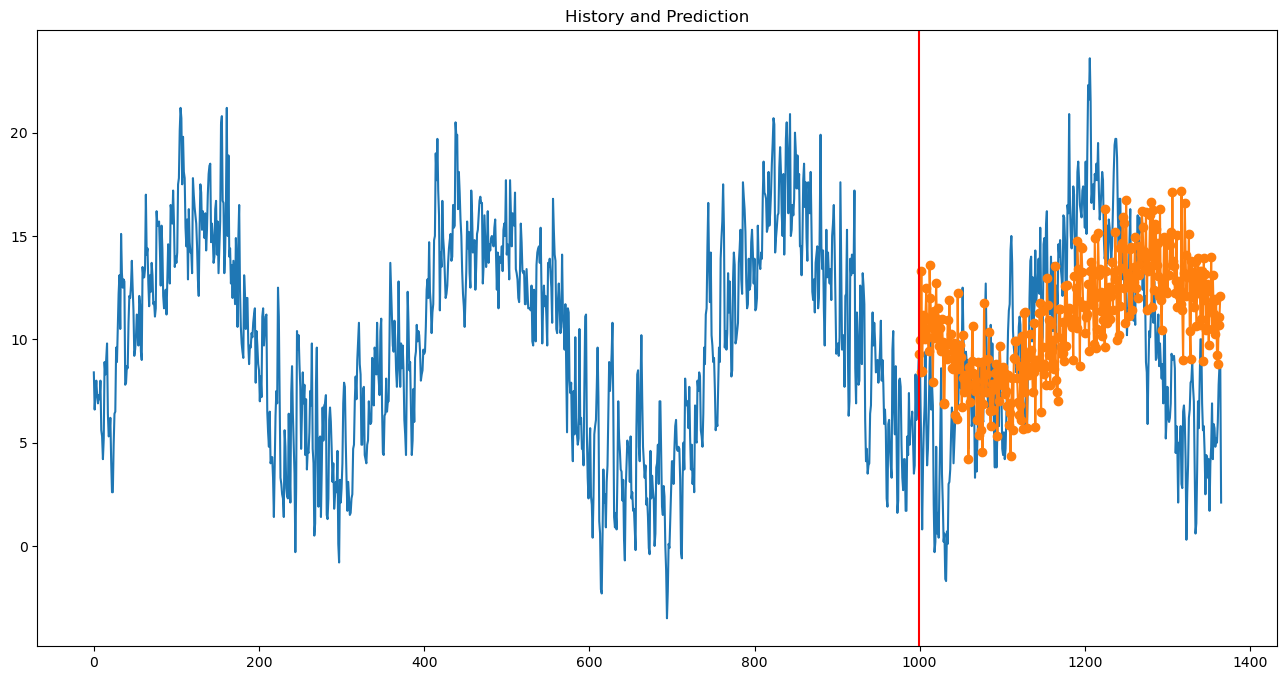

In [18]:
model.eval()  
with torch.no_grad():
    input_2019 = X_feas_norm[-(seq_len+output_size):-output_size].reshape(1,-1,input_size)
    input_2019 = torch.tensor(input_2019, dtype=torch.float32).to(device)
    target_2019 = Y_pred[-output_size:]
    pred_2019 = model(input_2019)
    target_2019_real = Y_pred[-(seq_len+output_size):]
    pred_2019_real = scaler2.inverse_transform(pred_2019.cpu()).reshape(366,)
    
     # Generate x-axis coordinates for data
    history_x = range(seq_len+output_size)
    plt.figure(figsize=(16, 8))
    prediction_x = range(seq_len - 1, seq_len+output_size - 1)
 
    # Plotting of historical data
    plt.plot(history_x, target_2019_real, label='History')
 
    # Plotting of projected data
    plt.plot(prediction_x, pred_2019_real, marker='o', label='Prediction')
    plt.axvline(seq_len - 1, color='red')  
    plt.title("History and Prediction")
    plt.show()


In [19]:
model.eval()  
with torch.no_grad():
    input_2020 = X_feas_norm[-seq_len:].reshape(1,-1,input_size)
    input_2020 = torch.tensor(input_2020, dtype=torch.float32).to(device)
    pred_2020 = model(input_2020)
    pred_2020_real = scaler2.inverse_transform(pred_2020.cpu()).reshape(366,)

In [20]:
pred_2020_real

array([ 8.93437063,  9.90912564,  8.49909521, 13.05861928,  8.32128735,
       11.01254773, 10.53613851,  9.80084231, 10.83569744, 12.15747591,
       10.15178565,  9.83385566,  9.70442611, 13.2784827 , 11.73299658,
       10.91106894, 10.72275167,  8.0823123 , 11.20342119,  9.97077459,
       10.8984473 , 12.41950238, 10.08531897, 11.35766799, 10.98651809,
        9.61765332, 10.47176416,  9.54524412, 10.94828287,  9.8987735 ,
        7.34281552,  7.31067413, 10.00320863,  9.43498194,  9.26990919,
       11.03737892,  9.77088482, 11.63509326, 10.01485279, 10.30847317,
        8.88387212,  8.87740203,  9.80178794,  9.82310338,  6.84684474,
        9.40860789,  6.4656025 , 12.18714871,  8.68953468,  9.74736955,
        9.82244244,  9.55821415,  7.12489512, 10.34551191,  8.71906812,
        7.83372569,  8.75549967,  8.10957823,  8.22724019,  8.42250534,
        4.80734381,  8.889305  ,  7.36311068,  8.87921963,  9.24024833,
       10.9069898 ,  8.79063323,  8.14640396,  8.14214565,  8.28

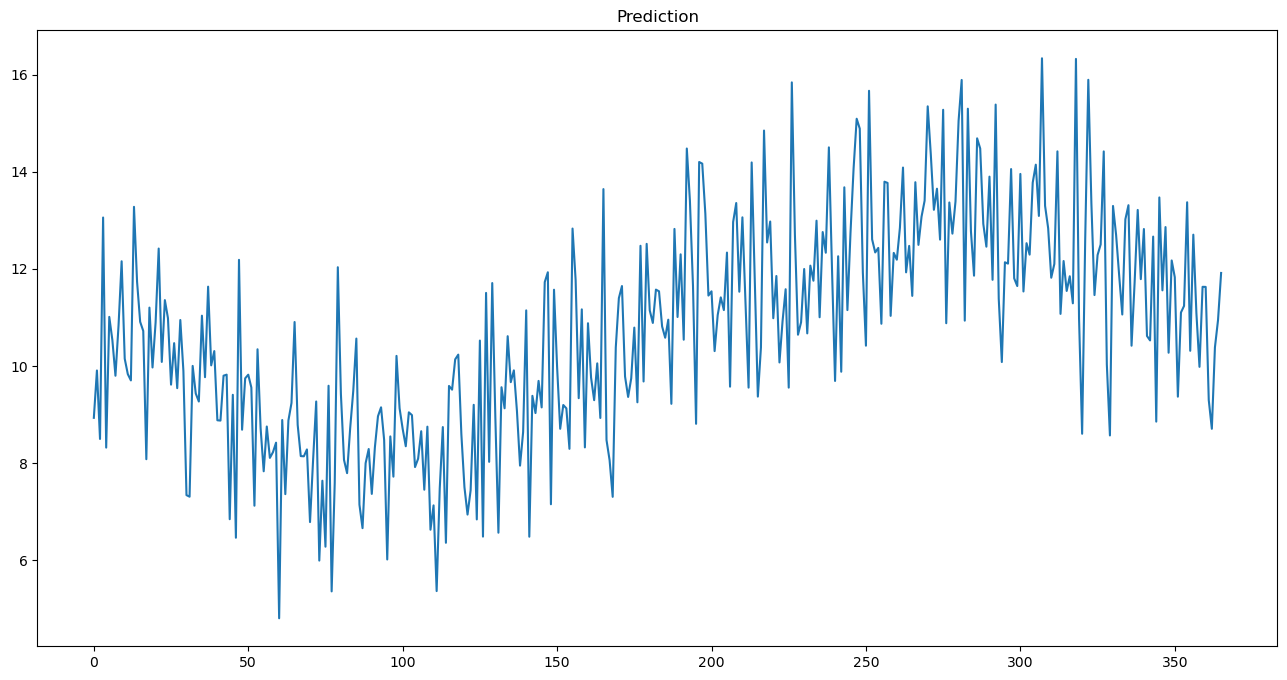

In [21]:
plt.figure(figsize=(16, 8))
prediction_x = range(output_size)
plt.plot(prediction_x, pred_2020_real, label='Prediction')
plt.title("Prediction")
plt.show()